1. Seq_to_Seq LSTM Traffic Prediction

Train shape: (21708, 10, 6), Test shape: (5427, 10, 6)
Train targets shape: (21708, 6, 5), Test targets shape: (5427, 6, 5)
Train IDs shape: (21708,), Test IDs shape: (5427,)
Using device: cuda
Epoch 1/20 - Train Loss: 0.0169
Epoch 2/20 - Train Loss: 0.0099
Epoch 3/20 - Train Loss: 0.0093
Epoch 4/20 - Train Loss: 0.0085
Epoch 5/20 - Train Loss: 0.0080
Epoch 6/20 - Train Loss: 0.0078
Epoch 7/20 - Train Loss: 0.0072
Epoch 8/20 - Train Loss: 0.0070
Epoch 9/20 - Train Loss: 0.0069
Epoch 10/20 - Train Loss: 0.0069
Epoch 11/20 - Train Loss: 0.0067
Epoch 12/20 - Train Loss: 0.0068
Epoch 13/20 - Train Loss: 0.0067
Epoch 14/20 - Train Loss: 0.0068
Epoch 15/20 - Train Loss: 0.0068
Epoch 16/20 - Train Loss: 0.0066
Epoch 17/20 - Train Loss: 0.0068
Epoch 18/20 - Train Loss: 0.0065
Epoch 19/20 - Train Loss: 0.0066
Epoch 20/20 - Train Loss: 0.0065
Model saved as seq2seq_lstm_multistep_with_extraData.pth
Using device: cuda

Evaluation Metrics for All 5 Targets:

 rnti_count Evaluation:
  - MSE   : 0.0

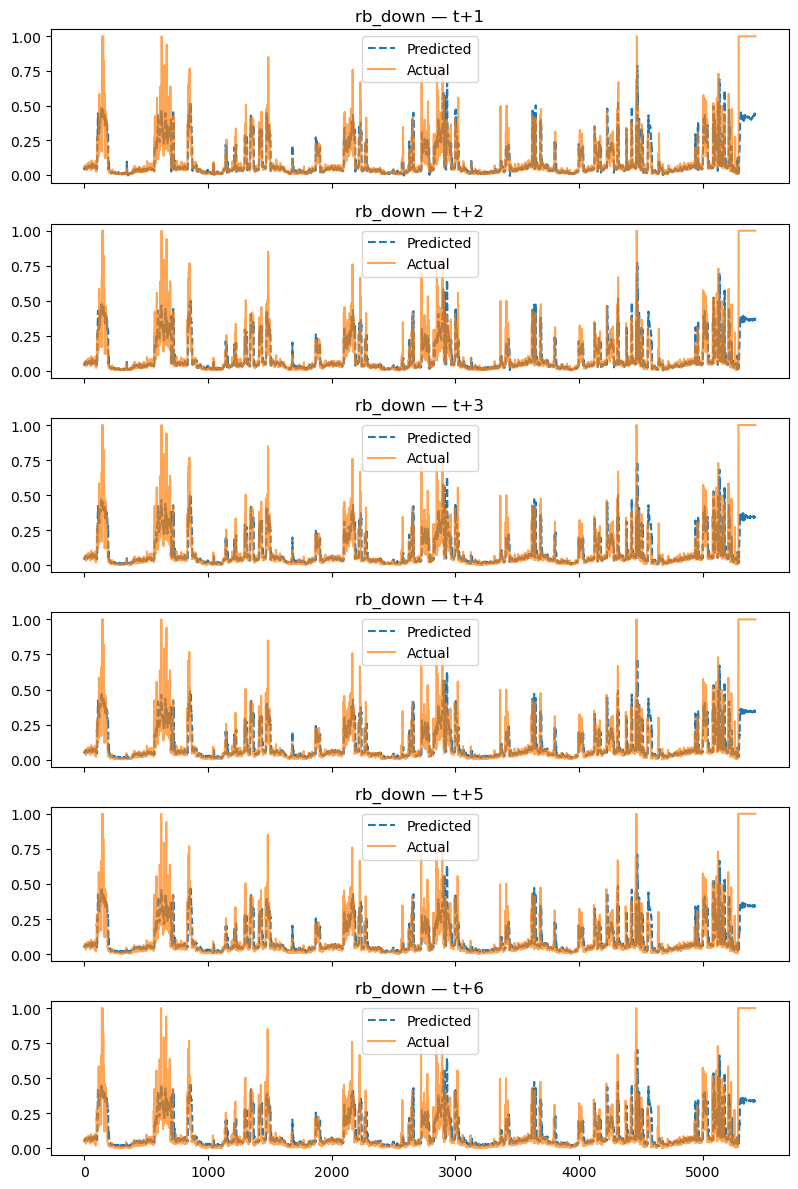

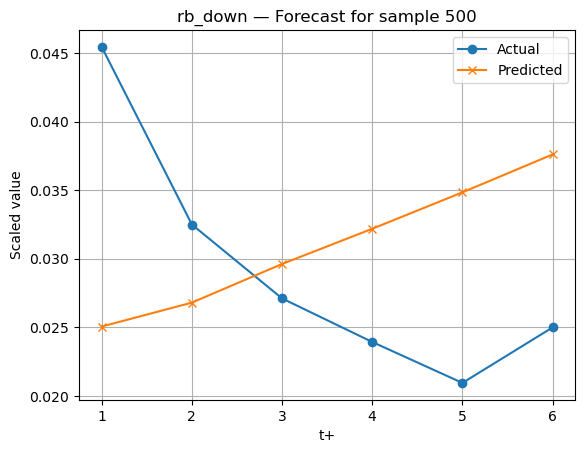


Forecast plots for down


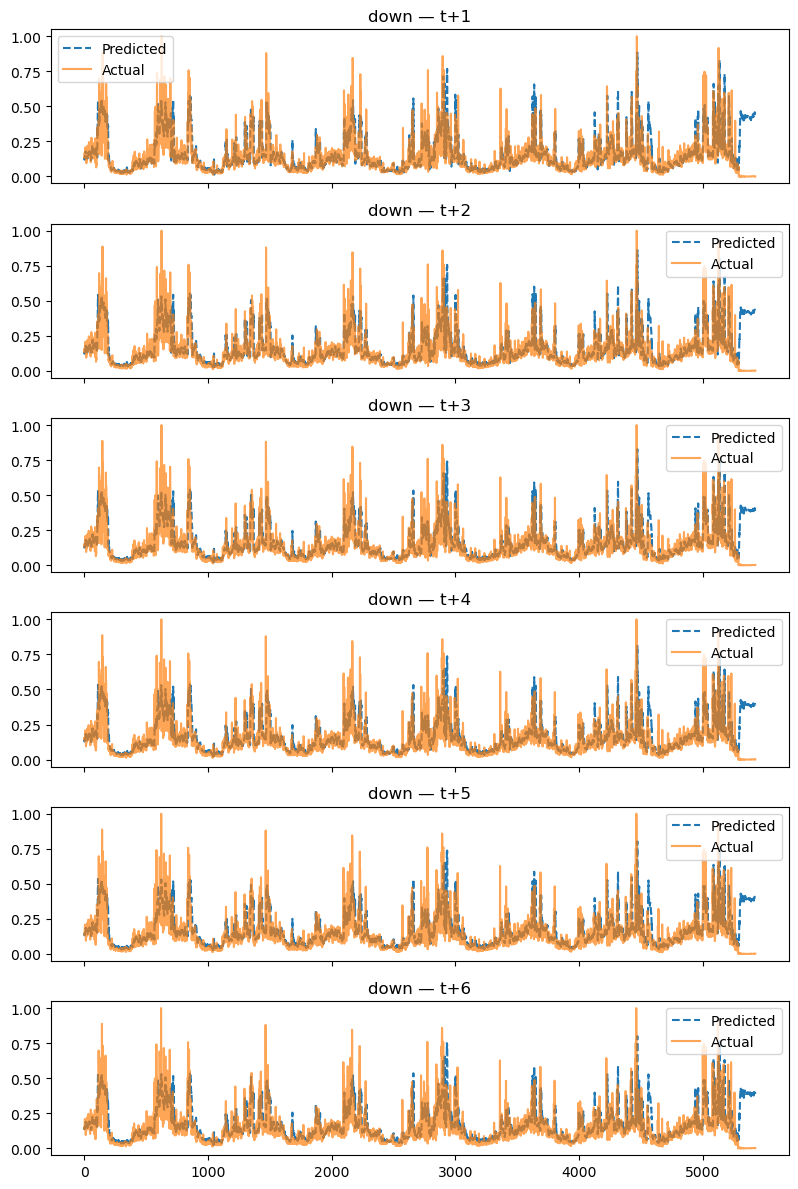

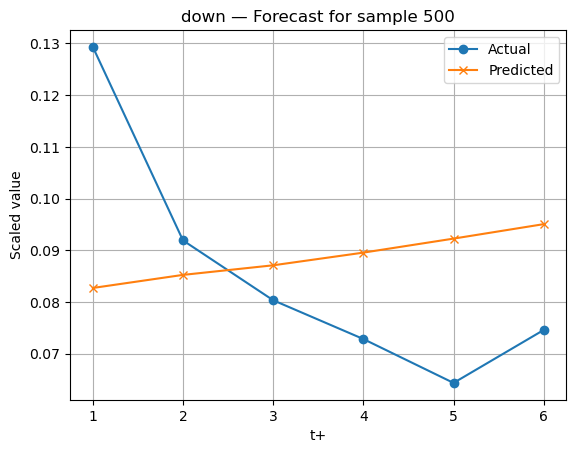

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Add the parent directory of 'ml' to sys.path
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import warnings
warnings.filterwarnings('ignore')

from torch.utils.data import DataLoader, TensorDataset
from ml.models.seq2seq_lstm import Seq2SeqLSTM
from ml.utils.data_utils import prepare_dataset
from argparse import Namespace
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Testing the prepare_dataset function with a sample configuration

args = Namespace(
    data_path='../dataset/full_dataset_with_extraData.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    identifier='District',
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True
)

# getting process data from prepared dataset function earlier defined in data_utils file

X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train targets shape: {y_train.shape}, Test targets shape: {y_test.shape}")
print(f"Train IDs shape: {id_train.shape}, Test IDs shape: {id_test.shape}")

# ─────────────────────────────────────────────────────────────
# STEP 1: Configurations
args = Namespace(
    data_path='../dataset/full_dataset_with_extraData.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    identifier='District',   
    batch_size=128,
    lr=0.001,
    epochs=20,
    cuda=True,
    seed=42
)

# ─────────────────────────────────────────────────────────────
# STEP 2: Set seed and device
torch.manual_seed(args.seed)
device = torch.device("cuda" if args.cuda and torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ─────────────────────────────────────────────────────────────
# STEP 3: Load and prepare data
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=args.batch_size, shuffle=False)

# ─────────────────────────────────────────────────────────────
# STEP 4: Model initialization
input_dim = X_train.shape[2]
output_dim = y_train.shape[2]
model = Seq2SeqLSTM(input_size=input_dim,
                    hidden_size=64,
                    output_size=output_dim,
                    forecast_steps=args.forecast_steps,
                    num_layers=1).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

# ─────────────────────────────────────────────────────────────
# STEP 5: Training Loop
for epoch in range(args.epochs):
    model.train()
    total_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb, teacher_forcing_ratio=0.5, decoder_targets=yb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{args.epochs} - Train Loss: {avg_loss:.4f}")

    # ─────────────────────────────────────────────────────────────
# STEP 6: Save model
torch.save(model.state_dict(), "seq2seq_lstm_multistep_with_extraData.pth")
print("Model saved as seq2seq_lstm_multistep_with_extraData.pth")

# ─────────────────────────────────────────────────────────────

                        #Evaluation

# ─────────────────────────────────────────────────────────────
# STEP 1: Setup arguments
args = Namespace(
    data_path='../dataset/full_dataset_with_extraData.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    identifier='District',
    batch_size=128,
    cuda=True,
    seed=42
)

device = torch.device("cuda" if args.cuda and torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ─────────────────────────────────────────────────────────────
# STEP 2: Load test data
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)

X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)

# ─────────────────────────────────────────────────────────────
# STEP 3: Load model
model = Seq2SeqLSTM(input_size=X_test.shape[2],
                    hidden_size=64,
                    output_size=y_test.shape[2],
                    forecast_steps=args.forecast_steps,
                    num_layers=1).to(device)

model.load_state_dict(torch.load("seq2seq_lstm_multistep_with_extraData.pth", map_location=device))
model.eval()

# ─────────────────────────────────────────────────────────────
# STEP 4: Inference
with torch.no_grad():
    preds = model(X_test_t, teacher_forcing_ratio=0)  # shape: [N, 6, 5]

preds = preds.cpu().numpy()
y_test = y_test  # still numpy

# ─────────────────────────────────────────────────────────────
# STEP 5: Evaluation Metrics MSE, RMSE, MAE, Rsquared, NRMSE
def evaluate(pred, actual, name):
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    nrmse = rmse / (actual.max() - actual.min())

    print(f"\n {name} Evaluation:")
    print(f"  - MSE   : {mse:.4f}")
    print(f"  - RMSE  : {rmse:.4f}")
    print(f"  - MAE   : {mae:.4f}")
    print(f"  - R²    : {r2:.4f}")
    print(f"  - NRMSE : {nrmse:.4f}")

# Loop through all target variables
print("\nEvaluation Metrics for All 5 Targets:")
for var in args.targets:
    idx = args.targets.index(var)
    pred_values = preds[:, :, idx].flatten()
    true_values = y_test[:, :, idx].flatten()
    evaluate(pred_values, true_values, var)


# ─────────────────────────────────────────────────────────────
# STEP 6: Visualizations

def plot_all_steps(preds, y_test, var_name):
    idx = args.targets.index(var_name)
    fig, axs = plt.subplots(6, 1, figsize=(8, 12), sharex=True)
    for t in range(6):
        axs[t].plot(preds[:, t, idx], label='Predicted', linestyle='--')
        axs[t].plot(y_test[:, t, idx], label='Actual', alpha=0.7)
        axs[t].set_title(f"{var_name} — t+{t+1}")
        axs[t].legend()
    plt.tight_layout()
    plt.show()

def plot_sample_steps(preds, y_test, sample_idx, var_name):
    idx = args.targets.index(var_name)
    plt.plot(range(1, 7), y_test[sample_idx, :, idx], label="Actual", marker='o')
    plt.plot(range(1, 7), preds[sample_idx, :, idx], label="Predicted", marker='x')
    plt.title(f"{var_name} — Forecast for sample {sample_idx}")
    plt.xlabel("t+")
    plt.ylabel("Scaled value")
    plt.xticks(range(1, 7))
    plt.grid(True)
    plt.legend()
    plt.show()


# ───────────── Plot both variables ─────────────
for var in ['rb_down', 'down']:
    print(f"\nForecast plots for {var}")
    plot_all_steps(preds, y_test, var)
    plot_sample_steps(preds, y_test, sample_idx=500, var_name=var)

2. Clustering

Combined shape: (27151, 13)


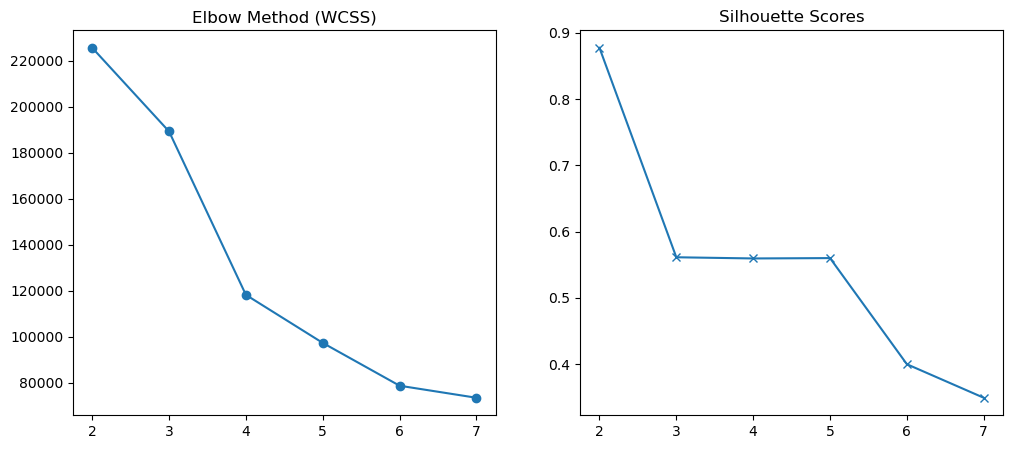


🔍 KMeans Clustering:
Silhouette Score: 0.5613491176286152
Calinski-Harabasz Index: 7842.491584084037

🔍 DBSCAN Clustering:
Silhouette Score: 0.7712645198422138
Calinski-Harabasz Index: 1548.305917562319

🔍 Hierarchical Clustering:
Silhouette Score: 0.5557451704608548
Calinski-Harabasz Index: 15091.856976233294


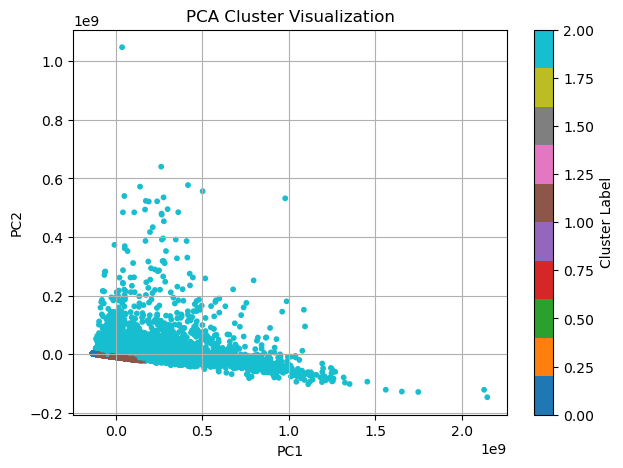

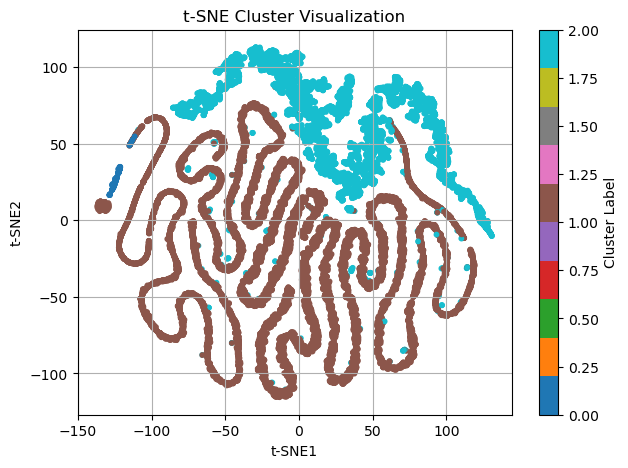

,time,down,up,rnti_count,mcs_down,mcs_down_var,mcs_up,mcs_up_var,rb_down,rb_down_var,rb_up,rb_up_var,District,Cluster_Feature
0,2018-03-28 15:56:00,174876888.0,1856888.0,10229.0,15.332298,87.157688,14.981497,49.989484,0.029681,4.497698e-08,0.000541,3.143297e-08,ElBorn,1
1,2018-03-28 15:58:00,209054184.0,2866200.0,12223.0,15.116846,87.192168,16.432612,62.494670,0.035971,4.615535e-08,0.000852,4.439640e-08,ElBorn,1
2,2018-03-28 16:00:00,191464640.0,1935360.0,11152.0,15.215739,87.227955,15.885238,63.087007,0.032750,4.646104e-08,0.000607,2.993595e-08,ElBorn,1
3,2018-03-28 16:02:00,241515688.0,2991152.0,14040.0,15.135400,86.199501,15.714660,77.187459,0.041372,4.532153e-08,0.000925,5.382563e-08,ElBorn,1
4,2018-03-28 16:04:00,264131088.0,3288816.0,15247.0,15.188944,86.151119,15.414080,69.118561,0.045074,4.655543e-08,0.001021,5.922178e-08,ElBorn,1


In [3]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score

#Use the combined dataset for 

path = '../dataset/'

# Load and tag source
df_all = pd.read_csv(path+"full_dataset_with_extraData.csv")
print(f"Combined shape: {df_all.shape}")
df_all.head(2)

#--------------------------------------------------
# Data Preprocessing
#--------------------------------------------------
# Drop non-numeric + time column
features = df_all.drop(columns=["time", "District"])

# Fill NA values
features = features.fillna(features.mean())

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

#--------------------------------------------------
#Determine optimal number of clusters
#--------------------------------------------------

# Calculate WCSS (Within-Cluster Sum of Squares) and Silhouette Scores for different cluster counts
wcss = [] # List to store WCSS for each k
silhouette_scores = [] # List to store silhouette scores for each k

for k in range(2, 8):
    model = KMeans(n_clusters=k, random_state=42)
    preds = model.fit_predict(X_scaled)
    wcss.append(model.inertia_) # Inertia is the WCSS for current k
    silhouette_scores.append(silhouette_score(X_scaled, preds)) # How well clusters are separated

# Plot the Elbow Method and Silhouette Scores
plt.figure(figsize=(12, 5))

# Elbow Method plot: helps to visually determine the optimal number of clusters (look for the "elbow")
plt.subplot(1, 2, 1)
plt.plot(range(2, 8), wcss, marker='o')
plt.title('Elbow Method (WCSS)')

# Silhouette Score plot: higher values mean better-defined clusters
plt.subplot(1, 2, 2)
plt.plot(range(2, 8), silhouette_scores, marker='x')
plt.title('Silhouette Scores')
plt.show()

#--------------------------------------------------
#Run different clustering algorithms
#--------------------------------------------------
# Define a dictionary of clustering models to compare
models = {
    "KMeans": KMeans(n_clusters=3, random_state=42),        
    "DBSCAN": DBSCAN(eps=1.5, min_samples=5),
    "Hierarchical": AgglomerativeClustering(n_clusters=3)
}

# Fit each clustering model and store the resulting cluster labels in the dataframe
for name, model in models.items():
    labels = model.fit_predict(X_scaled)
    df_all[f"{name}_Cluster"] = labels

#--------------------------------------------------
# Evaluate clustering performance using Silhouette Score and Calinski-Harabasz Index
#--------------------------------------------------
# Calculate and print clustering metrics for each model
for name in models.keys():
    labels = df_all[f"{name}_Cluster"]
    if len(set(labels)) > 1:
        print(f"\n🔍 {name} Clustering:")
        print("Silhouette Score:", silhouette_score(X_scaled, labels))
        print("Calinski-Harabasz Index:", calinski_harabasz_score(X_scaled, labels))
    else:
        print(f"\n⚠️ {name} returned only 1 cluster — skipping metrics.")

#--------------------------------------------------
# Visualize clusters using PCA and t-SNE
#--------------------------------------------------

# Use the best cluster result
features = df_all.drop(columns=["time", "District", "KMeans_Cluster", "DBSCAN_Cluster"])  # Kept Hierarchical_Cluster

X = features.select_dtypes(include=[float, int]).fillna(0).values
labels = df_all["Hierarchical_Cluster"]

# PCA Visualization
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(X)

plt.figure(figsize=(7, 5))
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=labels, cmap='tab10', s=10)
plt.title("PCA Cluster Visualization")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

# t-SNE Visualization (slower)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_2d = tsne.fit_transform(X)

plt.figure(figsize=(7, 5))
plt.scatter(tsne_2d[:, 0], tsne_2d[:, 1], c=labels, cmap='tab10', s=10)
plt.title("t-SNE Cluster Visualization")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

# ─────────────────────────────────────────────────────────────
#Add cluster as feature to the original dataset
#-────────────────────────────────────────────────────────────
# Convert cluster column to numeric type
df_all["Hierarchical_Cluster"] = df_all["Hierarchical_Cluster"].astype(int)

# Add to main features
df_all["Cluster_Feature"] = df_all["Hierarchical_Cluster"]

df_all = df_all.drop(columns=["KMeans_Cluster", "DBSCAN_Cluster", "Hierarchical_Cluster"])  # Keep only Hierarchical_Cluster

# Save and use in prepare_dataset
df_all.to_csv(path+"combined_with_cluster_feature_with_extraData.csv", index=False)

df_all.head(5)

3. Seq to seq with cluster feature

Epoch 1/50 - Train Loss: 2.8828
Epoch 2/50 - Train Loss: 2.3052
Epoch 3/50 - Train Loss: 2.1506
Epoch 4/50 - Train Loss: 1.8609
Epoch 5/50 - Train Loss: 1.7529
Epoch 6/50 - Train Loss: 1.6874
Epoch 7/50 - Train Loss: 1.6545
Epoch 8/50 - Train Loss: 1.6386
Epoch 9/50 - Train Loss: 1.6174
Epoch 10/50 - Train Loss: 1.6051
Epoch 11/50 - Train Loss: 1.5925
Epoch 12/50 - Train Loss: 1.5800
Epoch 13/50 - Train Loss: 1.5618
Epoch 14/50 - Train Loss: 1.5656
Epoch 15/50 - Train Loss: 1.5612
Epoch 16/50 - Train Loss: 1.5550
Epoch 17/50 - Train Loss: 1.5447
Epoch 18/50 - Train Loss: 1.5445
Epoch 19/50 - Train Loss: 1.5303
Epoch 20/50 - Train Loss: 1.5493
Epoch 21/50 - Train Loss: 1.5229
Epoch 22/50 - Train Loss: 1.5225
Epoch 23/50 - Train Loss: 1.5161
Epoch 24/50 - Train Loss: 1.5079
Epoch 25/50 - Train Loss: 1.5027
Epoch 26/50 - Train Loss: 1.4950
Epoch 27/50 - Train Loss: 1.4950
Epoch 28/50 - Train Loss: 1.5015
Epoch 29/50 - Train Loss: 1.4833
Epoch 30/50 - Train Loss: 1.4725
Epoch 31/50 - Train

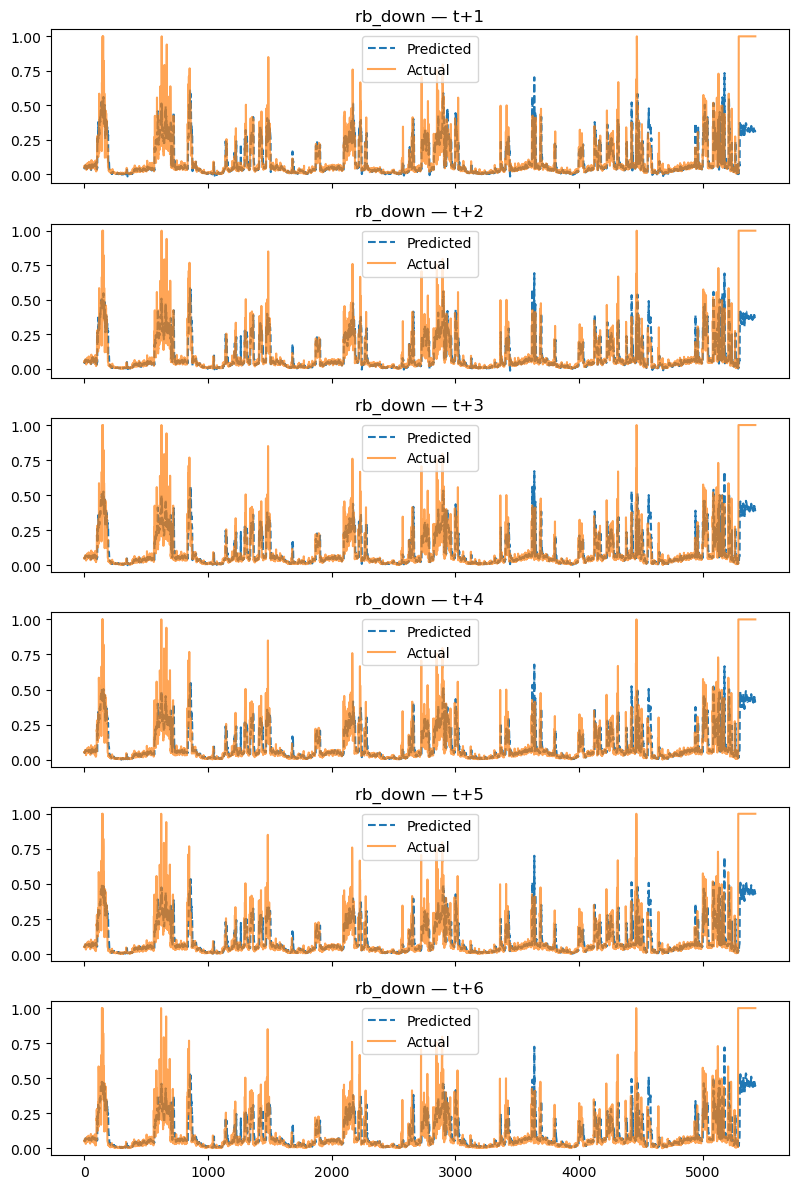

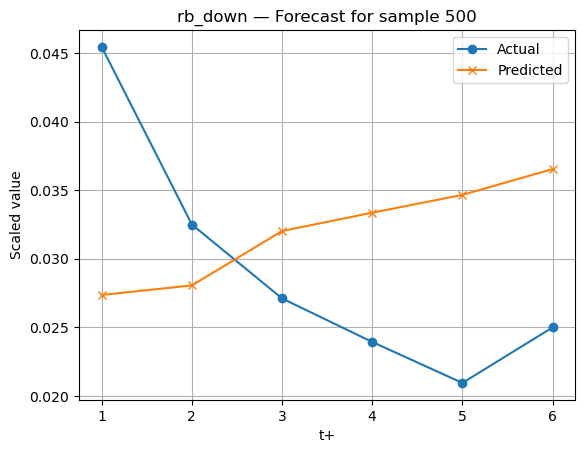


 Forecast plots for down


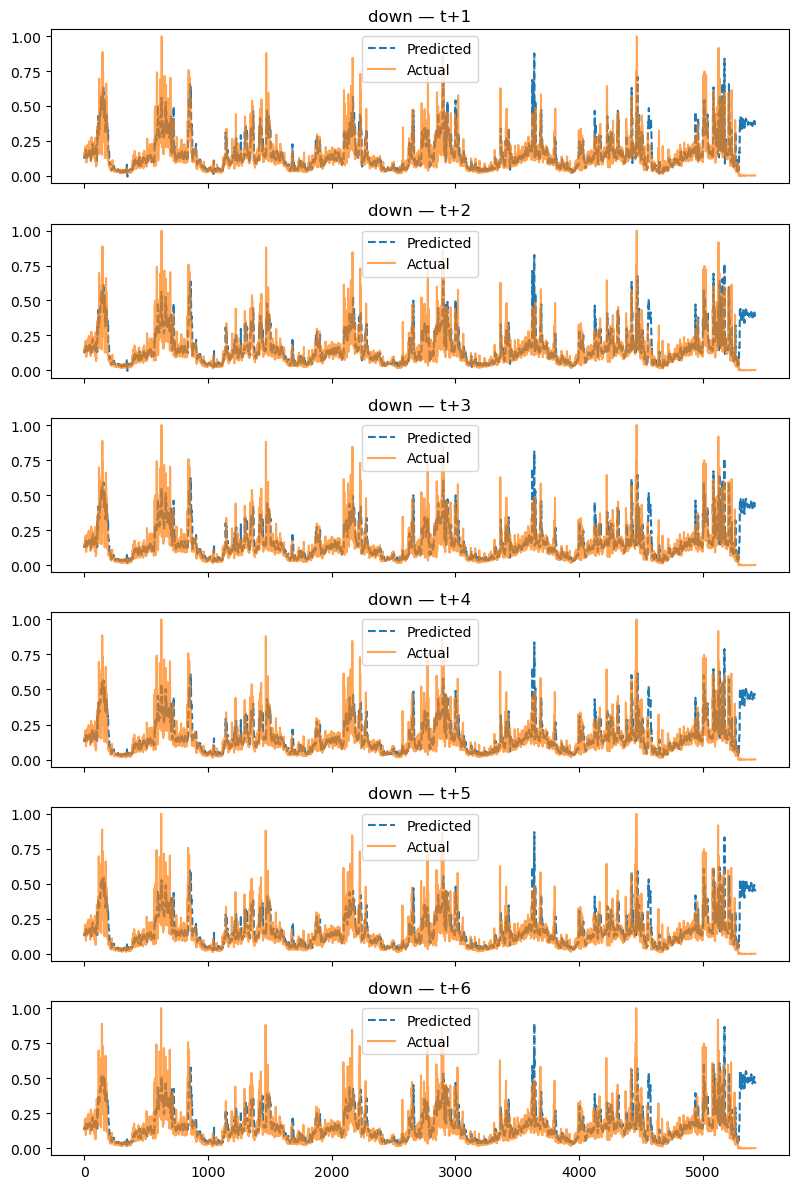

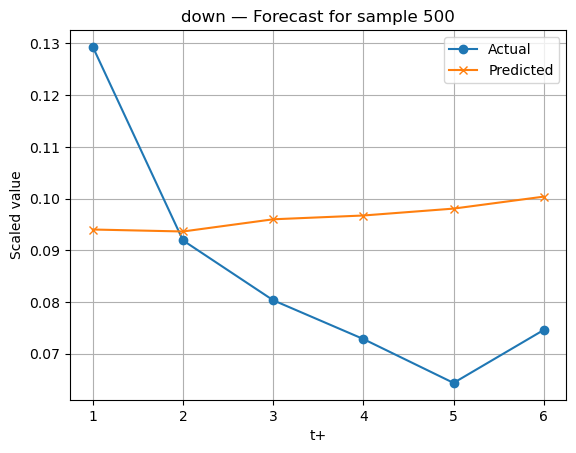

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Add the parent directory of 'ml' to sys.path
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import warnings
warnings.filterwarnings('ignore')

from types import SimpleNamespace as Namespace
from ml.models.seq2seq_lstm import Seq2SeqLSTM
from ml.utils.data_utils import prepare_dataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ─────────────────────────────────────────────────────────────
# STEP 1: Define Config
args = Namespace(
    data_path='../dataset/combined_with_cluster_feature_with_extraData.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    identifier='District',
    use_time_features=False
)

# ─────────────────────────────────────────────────────────────
# STEP 2: Load Data with Cluster Feature
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)

# ─────────────────────────────────────────────────────────────
# STEP 3: Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

# ─────────────────────────────────────────────────────────────
# STEP 4: Model Init & Training
input_dim = X_train.shape[-1]
output_dim = y_train.shape[-1]
forecast_steps = args.forecast_steps
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Seq2SeqLSTM(
    input_size=input_dim,
    hidden_size=64,
    output_size=output_dim,
    forecast_steps=forecast_steps
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.HuberLoss()  # More robust than MSE

# Training
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss:.4f}")

    # Save model
torch.save(model.state_dict(), "seq2seq_cluster_with_extra_data.pt")

# ─────────────────────────────────────────────────────────────
# STEP 5: Evaluation
# -────────────────────────────────────────────────────────────

import torch
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace as Namespace
from sklearn.metrics import mean_squared_error, mean_absolute_error

from ml.utils.data_utils import prepare_dataset
from ml.models.seq2seq_lstm import Seq2SeqLSTM

# ─────────────────────────────────────────────────────────────
# STEP 1: Setup arguments
args = Namespace(
    data_path='../dataset/combined_with_cluster_feature_with_extraData.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    identifier='District',
    use_time_features=False
)

# ─────────────────────────────────────────────────────────────
# STEP 2: Load test data
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)

X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)

# ─────────────────────────────────────────────────────────────
# STEP 3: Load model
model = Seq2SeqLSTM(input_size=X_test.shape[2],
                    hidden_size=64,
                    output_size=y_test.shape[2],
                    forecast_steps=args.forecast_steps,
                    num_layers=1).to(device)

model.load_state_dict(torch.load("seq2seq_cluster_with_extra_data.pt", map_location=device))
model.eval()

# ─────────────────────────────────────────────────────────────
# STEP 4: Inference
with torch.no_grad():
    preds = model(X_test_t, teacher_forcing_ratio=0)  # shape: [N, 6, 5]

preds = preds.cpu().numpy()
y_test = y_test  # still numpy

# ─────────────────────────────────────────────────────────────
# STEP 5: Evaluation Metrics
def evaluate(pred, actual, name):
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    nrmse = rmse / (actual.max() - actual.min())

    print(f"\n {name} Evaluation:")
    print(f"  - MSE   : {mse:.4f}")
    print(f"  - RMSE  : {rmse:.4f}")
    print(f"  - MAE   : {mae:.4f}")
    print(f"  - R²    : {r2:.4f}")
    print(f"  - NRMSE : {nrmse:.4f}")

# Loop through all target variables
print("\nEvaluation Metrics for All 5 Targets:")
for var in args.targets:
    idx = args.targets.index(var)
    pred_values = preds[:, :, idx].flatten()
    true_values = y_test[:, :, idx].flatten()
    evaluate(pred_values, true_values, var)


# ─────────────────────────────────────────────────────────────
# STEP 6: Visualizations

def plot_all_steps(preds, y_test, var_name):
    idx = args.targets.index(var_name)
    fig, axs = plt.subplots(6, 1, figsize=(8, 12), sharex=True)
    for t in range(6):
        axs[t].plot(preds[:, t, idx], label='Predicted', linestyle='--')
        axs[t].plot(y_test[:, t, idx], label='Actual', alpha=0.7)
        axs[t].set_title(f"{var_name} — t+{t+1}")
        axs[t].legend()
    plt.tight_layout()
    plt.show()

def plot_sample_steps(preds, y_test, sample_idx, var_name):
    idx = args.targets.index(var_name)
    plt.plot(range(1, 7), y_test[sample_idx, :, idx], label="Actual", marker='o')
    plt.plot(range(1, 7), preds[sample_idx, :, idx], label="Predicted", marker='x')
    plt.title(f"{var_name} — Forecast for sample {sample_idx}")
    plt.xlabel("t+")
    plt.ylabel("Scaled value")
    plt.xticks(range(1, 7))
    plt.grid(True)
    plt.legend()
    plt.show()


# ───────────── Plot both variables ─────────────
for var in ['rb_down', 'down']:
    print(f"\n Forecast plots for {var}")
    plot_all_steps(preds, y_test, var)
    plot_sample_steps(preds, y_test, sample_idx=500, var_name=var)

Train shape: (21708, 10, 6), Test shape: (5427, 10, 6)
Train targets shape: (21708, 6, 5), Test targets shape: (5427, 6, 5)
Train IDs shape: (21708,), Test IDs shape: (5427,)
Using device: cuda
Epoch 1/20 - Train Loss: 0.0169
Epoch 2/20 - Train Loss: 0.0099
Epoch 3/20 - Train Loss: 0.0093
Epoch 4/20 - Train Loss: 0.0085
Epoch 5/20 - Train Loss: 0.0080
Epoch 6/20 - Train Loss: 0.0078
Epoch 7/20 - Train Loss: 0.0072
Epoch 8/20 - Train Loss: 0.0070
Epoch 9/20 - Train Loss: 0.0069
Epoch 10/20 - Train Loss: 0.0069
Epoch 11/20 - Train Loss: 0.0067
Epoch 12/20 - Train Loss: 0.0068
Epoch 13/20 - Train Loss: 0.0067
Epoch 14/20 - Train Loss: 0.0068
Epoch 15/20 - Train Loss: 0.0068
Epoch 16/20 - Train Loss: 0.0066
Epoch 17/20 - Train Loss: 0.0068
Epoch 18/20 - Train Loss: 0.0065
Epoch 19/20 - Train Loss: 0.0066
Epoch 20/20 - Train Loss: 0.0065
Model saved as seq2seq_lstm_multistep_with_extraData.pth
Using device: cuda

Evaluation Metrics for All 5 Targets:

 rnti_count Evaluation:
  - MSE   : 0.0

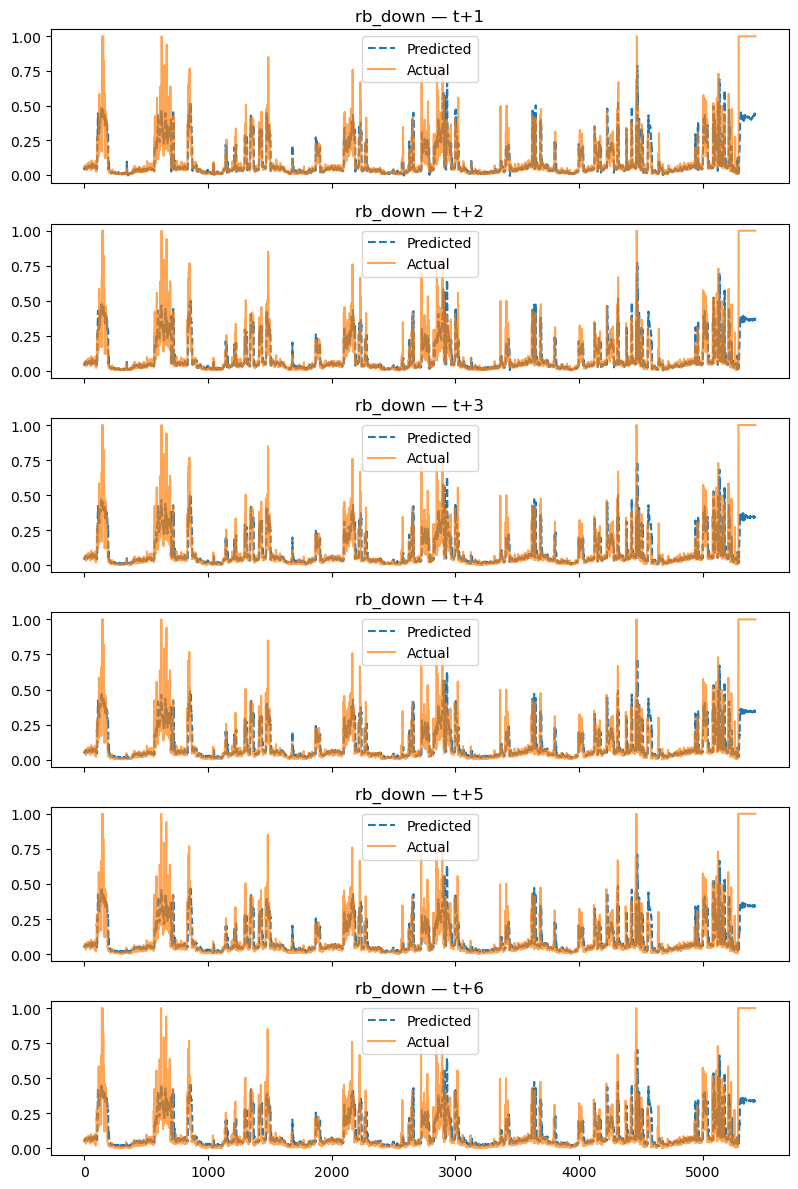

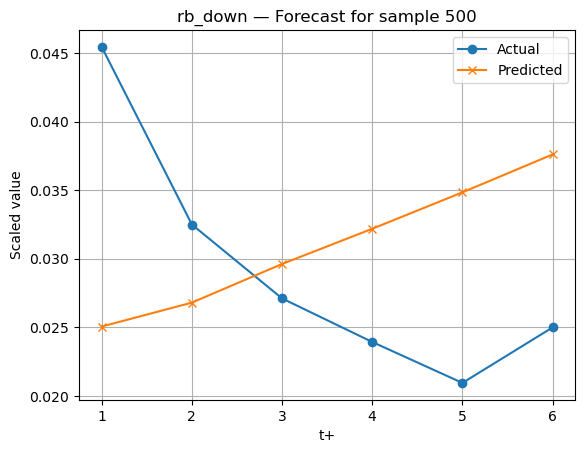


Forecast plots for down


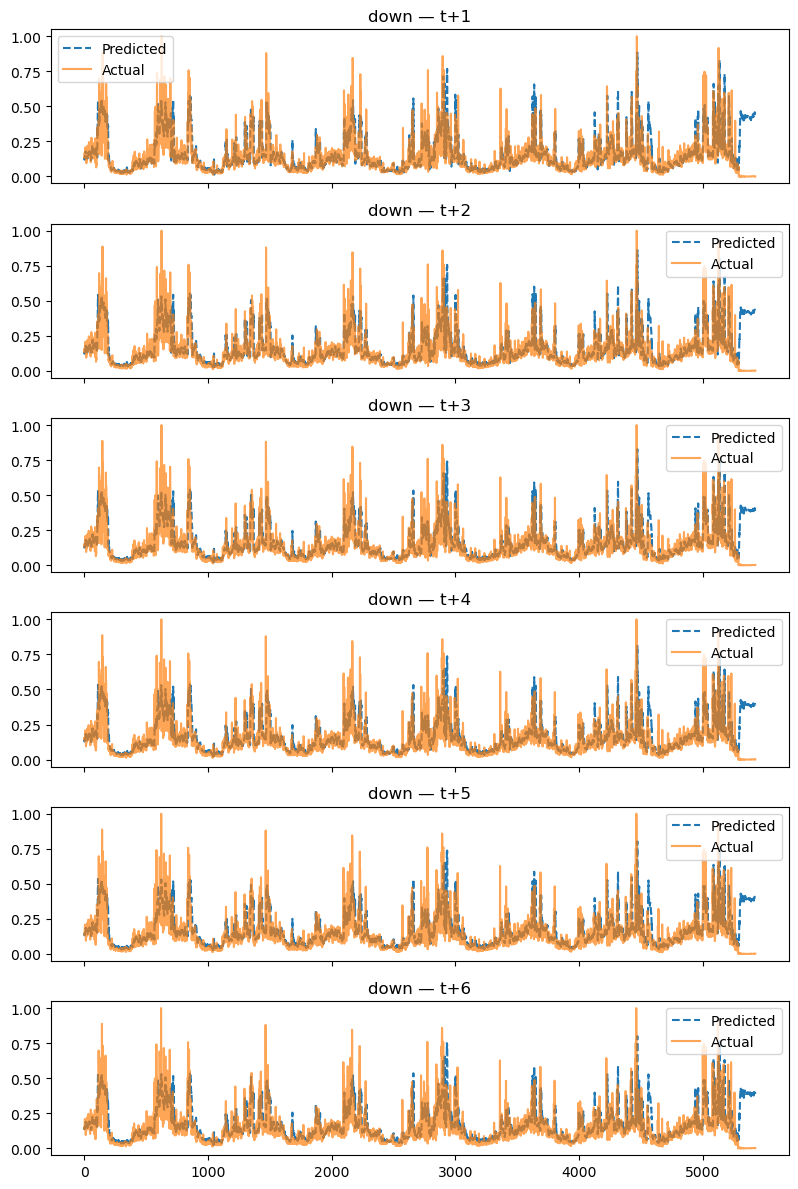

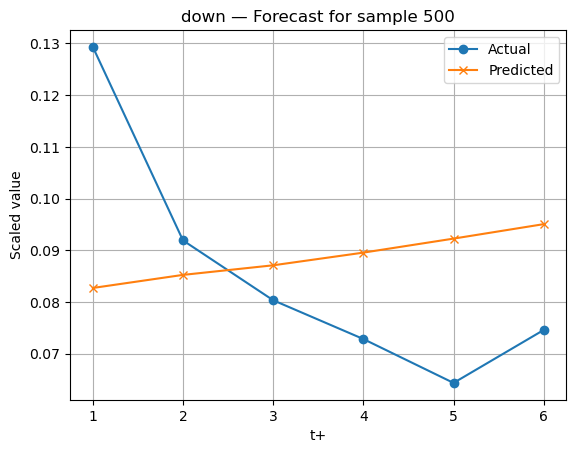

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Add the parent directory of 'ml' to sys.path
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import warnings
warnings.filterwarnings('ignore')

from torch.utils.data import DataLoader, TensorDataset
from ml.models.seq2seq_lstm import Seq2SeqLSTM
from ml.utils.data_utils import prepare_dataset
from argparse import Namespace
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Testing the prepare_dataset function with a sample configuration

args = Namespace(
    data_path='../dataset/full_dataset_with_extraData.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    identifier='District',
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True
)

# getting process data from prepared dataset function earlier defined in data_utils file

X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train targets shape: {y_train.shape}, Test targets shape: {y_test.shape}")
print(f"Train IDs shape: {id_train.shape}, Test IDs shape: {id_test.shape}")

# ─────────────────────────────────────────────────────────────
# STEP 1: Configurations
args = Namespace(
    data_path='../dataset/full_dataset_with_extraData.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    identifier='District',   
    batch_size=128,
    lr=0.001,
    epochs=20,
    cuda=True,
    seed=42
)

# ─────────────────────────────────────────────────────────────
# STEP 2: Set seed and device
torch.manual_seed(args.seed)
device = torch.device("cuda" if args.cuda and torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ─────────────────────────────────────────────────────────────
# STEP 3: Load and prepare data
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=args.batch_size, shuffle=False)

# ─────────────────────────────────────────────────────────────
# STEP 4: Model initialization
input_dim = X_train.shape[2]
output_dim = y_train.shape[2]
model = Seq2SeqLSTM(input_size=input_dim,
                    hidden_size=64,
                    output_size=output_dim,
                    forecast_steps=args.forecast_steps,
                    num_layers=1).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

# ─────────────────────────────────────────────────────────────
# STEP 5: Training Loop
for epoch in range(args.epochs):
    model.train()
    total_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb, teacher_forcing_ratio=0.5, decoder_targets=yb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{args.epochs} - Train Loss: {avg_loss:.4f}")

    # ─────────────────────────────────────────────────────────────
# STEP 6: Save model
torch.save(model.state_dict(), "seq2seq_lstm_multistep_with_extraData.pth")
print("Model saved as seq2seq_lstm_multistep_with_extraData.pth")

# ─────────────────────────────────────────────────────────────

                        #Evaluation

# ─────────────────────────────────────────────────────────────
# STEP 1: Setup arguments
args = Namespace(
    data_path='../dataset/full_dataset_with_extraData.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    identifier='District',
    batch_size=128,
    cuda=True,
    seed=42
)

device = torch.device("cuda" if args.cuda and torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ─────────────────────────────────────────────────────────────
# STEP 2: Load test data
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)

X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)

# ─────────────────────────────────────────────────────────────
# STEP 3: Load model
model = Seq2SeqLSTM(input_size=X_test.shape[2],
                    hidden_size=64,
                    output_size=y_test.shape[2],
                    forecast_steps=args.forecast_steps,
                    num_layers=1).to(device)

model.load_state_dict(torch.load("seq2seq_lstm_multistep_with_extraData.pth", map_location=device))
model.eval()

# ─────────────────────────────────────────────────────────────
# STEP 4: Inference
with torch.no_grad():
    preds = model(X_test_t, teacher_forcing_ratio=0)  # shape: [N, 6, 5]

preds = preds.cpu().numpy()
y_test = y_test  # still numpy

# ─────────────────────────────────────────────────────────────
# STEP 5: Evaluation Metrics MSE, RMSE, MAE, Rsquared, NRMSE
def evaluate(pred, actual, name):
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    nrmse = rmse / (actual.max() - actual.min())

    print(f"\n {name} Evaluation:")
    print(f"  - MSE   : {mse:.4f}")
    print(f"  - RMSE  : {rmse:.4f}")
    print(f"  - MAE   : {mae:.4f}")
    print(f"  - R²    : {r2:.4f}")
    print(f"  - NRMSE : {nrmse:.4f}")

# Loop through all target variables
print("\nEvaluation Metrics for All 5 Targets:")
for var in args.targets:
    idx = args.targets.index(var)
    pred_values = preds[:, :, idx].flatten()
    true_values = y_test[:, :, idx].flatten()
    evaluate(pred_values, true_values, var)


# ─────────────────────────────────────────────────────────────
# STEP 6: Visualizations

def plot_all_steps(preds, y_test, var_name):
    idx = args.targets.index(var_name)
    fig, axs = plt.subplots(6, 1, figsize=(8, 12), sharex=True)
    for t in range(6):
        axs[t].plot(preds[:, t, idx], label='Predicted', linestyle='--')
        axs[t].plot(y_test[:, t, idx], label='Actual', alpha=0.7)
        axs[t].set_title(f"{var_name} — t+{t+1}")
        axs[t].legend()
    plt.tight_layout()
    plt.show()

def plot_sample_steps(preds, y_test, sample_idx, var_name):
    idx = args.targets.index(var_name)
    plt.plot(range(1, 7), y_test[sample_idx, :, idx], label="Actual", marker='o')
    plt.plot(range(1, 7), preds[sample_idx, :, idx], label="Predicted", marker='x')
    plt.title(f"{var_name} — Forecast for sample {sample_idx}")
    plt.xlabel("t+")
    plt.ylabel("Scaled value")
    plt.xticks(range(1, 7))
    plt.grid(True)
    plt.legend()
    plt.show()


# ───────────── Plot both variables ─────────────
for var in ['rb_down', 'down']:
    print(f"\nForecast plots for {var}")
    plot_all_steps(preds, y_test, var)
    plot_sample_steps(preds, y_test, sample_idx=500, var_name=var)

4. Transformer

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from argparse import Namespace
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Add the parent directory of 'ml' to sys.path
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import warnings
warnings.filterwarnings('ignore')

from ml.models.transformer import TimeSeriesTransformer
from ml.utils.data_utils import prepare_dataset 

# -----------------------
# Config (cluster dataset)
# -----------------------
args = Namespace(
    data_path='../dataset/combined_with_cluster_feature_with_extraData.csv',  # <— clustered data
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,                  # encoder length (L)
    forecast_steps=6,             # horizon (H)
    test_size=0.2,                # 80/20 split
    ignore_cols=None,
    identifier='District',
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    use_time_features=False,      # (kept off to mirror your cluster runs)

    # Transformer model hyperparams (match your working eval config)
    d_model=128,
    nhead=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=256,
    dropout=0.1,

    # Training
    epochs=30,                    # you can bump this (e.g., 50) if needed
    batch_size=64,
    lr=1e-3,
    weight_decay=0.0,
    grad_clip=1.0,
    early_stopping_patience=8,    # stop if val loss doesn't improve

    device='cuda' if torch.cuda.is_available() else 'cpu',
    save_path='transformer_multistep_cluster_with_extra_data.pt',     # best checkpoint (weights)
    )

# -----------------------
# Load data
# -----------------------
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)
# Shapes
# X_*: [N, L, D]
# y_*: [N, H, T]
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test : {X_test.shape},  y_test : {y_test.shape}")

input_size  = X_train.shape[2]  # D
output_size = y_train.shape[2]  # T
L = X_train.shape[1]
H = y_train.shape[1]
assert L == args.num_lags and H == args.forecast_steps, "Check num_lags/forecast_steps vs data."

train_loader = DataLoader(
    TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                  torch.tensor(y_train, dtype=torch.float32)),
    batch_size=args.batch_size, shuffle=True, drop_last=False
)
val_loader = DataLoader(  # using test as validation for training loop; can split train if you prefer
    TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                  torch.tensor(y_test, dtype=torch.float32)),
    batch_size=args.batch_size, shuffle=False, drop_last=False
)

# -----------------------
# Build model
# -----------------------
model = TimeSeriesTransformer(
    input_size=input_size,
    output_size=output_size,
    forecast_steps=args.forecast_steps,
    d_model=args.d_model,
    nhead=args.nhead,
    num_encoder_layers=args.num_encoder_layers,
    num_decoder_layers=args.num_decoder_layers,
    dim_feedforward=args.dim_feedforward,
    dropout=args.dropout,
).to(args.device)

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
criterion = nn.MSELoss()

# Optional scheduler (cosine annealing works well for Transformers)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, args.epochs))

# -----------------------
# Train / Val loops
# -----------------------
best_val = float('inf')
best_epoch = -1
no_improve = 0

scaler_amp = torch.cuda.amp.GradScaler(enabled=(args.device == 'cuda'))

for epoch in range(1, args.epochs + 1):
    # ---- Train ----
    model.train()
    running = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(args.device), yb.to(args.device)
        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(args.device == 'cuda')):
            preds = model(xb)            # [B, H, T], trained on SCALED space
            loss = criterion(preds, yb)

        scaler_amp.scale(loss).backward()
        if args.grad_clip and args.grad_clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.grad_clip)
        scaler_amp.step(optimizer)
        scaler_amp.update()

        running += loss.item()

    train_loss = running / max(1, len(train_loader))

    # ---- Validate ----
    model.eval()
    with torch.no_grad():
        vloss = 0.0
        for xb, yb in val_loader:
            xb, yb = xb.to(args.device), yb.to(args.device)
            preds = model(xb)
            vloss += criterion(preds, yb).item()
        val_loss = vloss / max(1, len(val_loader))

    if scheduler is not None:
        scheduler.step()

    print(f"[{epoch:03d}/{args.epochs}] Train {train_loss:.6f} | Val {val_loss:.6f} | LR {optimizer.param_groups[0]['lr']:.2e}")

    # ---- Early Stopping + Best Save ----
    if val_loss < best_val - 1e-8:
        best_val = val_loss
        best_epoch = epoch
        no_improve = 0
        torch.save(model.state_dict(), args.save_path)
    else:
        no_improve += 1
        if no_improve >= args.early_stopping_patience:
            print(f"Early stopping at epoch {epoch} (best={best_val:.6f} @ {best_epoch})")
            break

X_train: (21708, 10, 7), y_train: (21708, 6, 5)
X_test : (5427, 10, 7),  y_test : (5427, 6, 5)
[001/30] Train 0.093033 | Val 0.025922 | LR 9.97e-04
[002/30] Train 0.016452 | Val 0.024215 | LR 9.89e-04
[003/30] Train 0.013537 | Val 0.019133 | LR 9.76e-04
[004/30] Train 0.012408 | Val 0.021338 | LR 9.57e-04
[005/30] Train 0.011783 | Val 0.019347 | LR 9.33e-04
[006/30] Train 0.011063 | Val 0.017901 | LR 9.05e-04
[007/30] Train 0.010446 | Val 0.018706 | LR 8.72e-04
[008/30] Train 0.010354 | Val 0.018179 | LR 8.35e-04
[009/30] Train 0.010219 | Val 0.017540 | LR 7.94e-04
[010/30] Train 0.010144 | Val 0.016579 | LR 7.50e-04
[011/30] Train 0.009958 | Val 0.016748 | LR 7.03e-04
[012/30] Train 0.009782 | Val 0.016018 | LR 6.55e-04
[013/30] Train 0.009570 | Val 0.016253 | LR 6.04e-04
[014/30] Train 0.009605 | Val 0.016282 | LR 5.52e-04
[015/30] Train 0.009411 | Val 0.016336 | LR 5.00e-04
[016/30] Train 0.009432 | Val 0.016290 | LR 4.48e-04
[017/30] Train 0.009321 | Val 0.016346 | LR 3.96e-04
[018